In [1]:
#Importing the packages we will be using
# Basic Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import seaborn as sns
import re
import string
from collections import Counter

# SK Packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score

## Vectorizers
from sklearn.feature_extraction.text import CountVectorizer

In this notebook, we will be creating our final dataframe to be used for modeling, as well as doing some EDA.

We will start by loading our two JSON files containing our data. 

Yes, you would ideally create a column that counts the number of reviews per movie before you aggregate (concatenate) the reviews. This way, you'll have that information readily available when you're normalizing later on.

Here's how you could go about it:

1. **Count the number of reviews per movie**: Use the `groupby` method on your `reviews_df` DataFrame to count the number of reviews for each `imdb_id`.

    ```python
    review_counts = reviews_df.groupby('imdb_id').size().reset_index(name='num_reviews')
    ```

2. **Merge this information back into your main DataFrame**: Before or after you concatenate the reviews, merge this count back into your main DataFrame (`clean_metadata_df`).

    ```python
    clean_metadata_df = pd.merge(clean_metadata_df, review_counts, on='imdb_id', how='left')
    ```

3. **Concatenate the reviews**: Assuming you have a DataFrame like `final_reviews_df_filtered`, where each row represents an `imdb_id` and its concatenated reviews:

    ```python
    aggregated_reviews = reviews_df.groupby('imdb_id')['review_text'].apply(' '.join).reset_index()
    ```

4. **Merge this aggregated data back into your main DataFrame**:

    ```python
    clean_metadata_df = pd.merge(clean_metadata_df, aggregated_reviews, on='imdb_id', how='left')
    ```

5. **Normalize after vectorization**: Once you've applied CountVectorizer to the concatenated reviews, divide the word counts by the number of reviews (the `num_reviews` column you created) for each movie.

By keeping track of the number of reviews in this manner, you'll be able to normalize your text features effectively.

Yes, your teacher's suggestion makes sense in certain contexts. Here's a breakdown of the two points:

1. **Normalizing Review Text Based on the Number of Reviews per Movie**: If some movies have a large number of reviews compared to others, they could dominate the feature space when you aggregate the review text. By normalizing, you're essentially "leveling the playing field" so that each movie's reviews have roughly the same weight, irrespective of the number of individual reviews. You could achieve this by calculating some sort of average for each movie's reviews rather than a total sum.

2. **Dividing Count Vectorizer Columns by the Number of Reviews**: When you apply a technique like Count Vectorizer, each column represents the frequency of a particular word across all reviews for a movie. However, if one movie has many more reviews than another, the word counts will naturally be higher, even if the word isn't particularly more relevant for that movie. By dividing the counts by the total number of reviews for each movie, you turn those raw counts into averages, making them more comparable across movies with differing numbers of reviews.

Here's a simplified example for point 2:

```python
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Sample data (each row represents aggregated review text for a movie)
data = {'imdb_id': ['id1', 'id2'], 'reviews': ['good good bad', 'bad good']}
df = pd.DataFrame(data)

# Number of reviews for each movie
num_reviews = {'id1': 3, 'id2': 2}

# Applying CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['reviews'])
count_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

# Dividing by the number of reviews for each movie
for index, row in count_df.iterrows():
    count_df.loc[index] = row / num_reviews[df.loc[index, 'imdb_id']]

# Adding back the imdb_id for reference
count_df['imdb_id'] = df['imdb_id']

print(count_df)
```

This normalization can make it easier to identify which words are truly indicative of a movie's characteristics, as it scales down the impact of movies that simply have more reviews.

In [95]:
# Group by 'item_id' and count the number of reviews ('txt') for each movie
reviews_count_per_movie = clean_reviews_df.groupby('item_id')['txt'].count()

# Calculate the minimum, maximum, and mean number of reviews
min_reviews_count = reviews_count_per_movie.min()
max_reviews_count = reviews_count_per_movie.max()
mean_reviews_count = np.mean(reviews_count_per_movie)

print(f'The minimum number of reviews for a movie is: {min_reviews_count}')
print(f'The maximum number of reviews for a movie is: {max_reviews_count}')
print(f'The mean number of reviews per movie is: {mean_reviews_count}')

The minimum number of reviews for a movie is: 1
The maximum number of reviews for a movie is: 5109
The mean number of reviews per movie is: 50.30396881780304


In [ ]:
plt.figure(figsize=(15, 5))

# Loop through each numerical column
for i, col in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i + 1)
    final_merged_df[col].hist()
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

In [ ]:
# Pairplot to see relationships between each feature
sns.pairplot(final_merged_df[numerical_columns])
plt.show()

In [ ]:
# Create correlation matrix
corr = final_merged_df[numerical_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Taking a closer look at ratings distribution
plt.figure(figsize=(10, 6))
sns.histplot(final_merged_df['rating'], bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Calculate word counts in review text
word_counts = clean_reviews_df['txt'].apply(lambda x: len(str(x).split()))

# Plot the histogram
plt.figure(figsize=(10, 6))
word_counts.hist(bins=50)
plt.title('Distribution of Word Counts in Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
Q1 = word_counts.quantile(0.25)
Q3 = word_counts.quantile(0.75)
IQR = Q3 - Q1

# Filter for data within 1.5 IQR of Q1 and Q3
filtered_word_counts = word_counts[(word_counts >= (Q1 - 1.5 * IQR)) & (word_counts <= (Q3 + 1.5 * IQR))]

plt.figure(figsize=(10, 6))
filtered_word_counts.hist(bins=50)
plt.title('Filtered Distribution of Word Counts in Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Filter out rows where budget is 0
filtered_budget = final_merged_df[final_merged_df['budget'] > 0]

plt.figure(figsize=(10, 6))

# Plot the scatter plot
plt.scatter(filtered_budget['budget'], filtered_budget['rating'], alpha=0.5)

plt.title('Relationship Between Rating and Budget')
plt.xlabel('Budget')
plt.ylabel('Rating')

plt.show()

In [126]:
from collections import Counter

# Flatten the list of lists and count occurrences of each genre
all_genres = [genre for sublist in final_merged_df['genre_names'].tolist() for genre in sublist]
genre_counts = Counter(all_genres)

print(genre_counts)

Counter({'Drama': 16327, 'Thriller': 10755, 'Action': 8990, 'Comedy': 8361, 'Horror': 7400, 'Crime': 6331, 'Adventure': 4760, 'Science Fiction': 4075, 'Romance': 4018, 'Mystery': 3683, 'Fantasy': 3142, 'Family': 2771, 'Music': 2197, 'Documentary': 2194, 'History': 1964, 'Animation': 1932, 'War': 1894, 'TV Movie': 1524, 'Western': 1489})


In [127]:
# Count occurrences of each unique combination
combo_counts = Counter(tuple(sorted(combo)) for combo in final_merged_df['genre_names'])

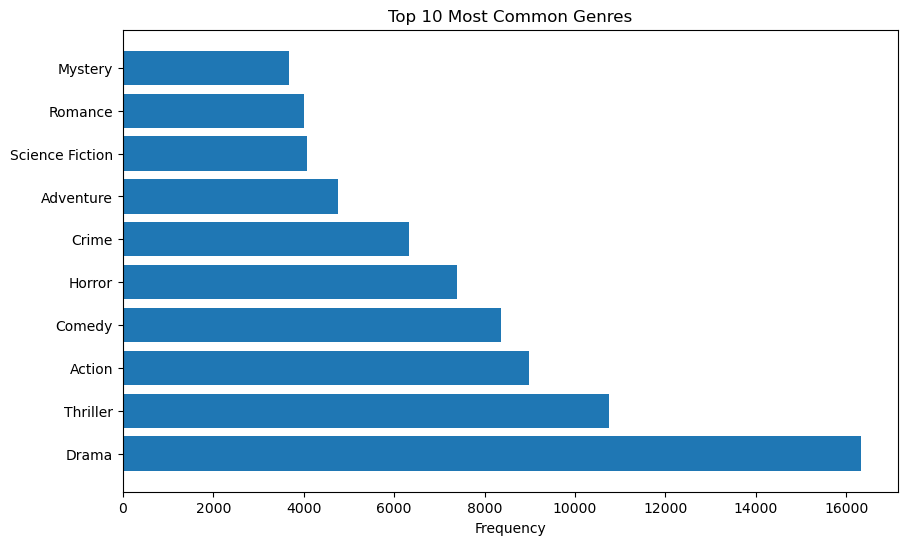

In [128]:
# Plotting the 10 most common individual genres
common_genres = genre_counts.most_common(10)
labels, values = zip(*common_genres)

plt.figure(figsize=(10, 6))
plt.barh(labels, values)
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Genres')
plt.show()

In [129]:
# Flatten the list of actors and count occurrences
all_actors = [actor for sublist in final_merged_df['actor_names'].tolist() for actor in sublist]
actor_counts = Counter(all_actors)

In [130]:
# Extract top 10 actors
top_actors = [actor for actor, _ in actor_counts.most_common(10)]

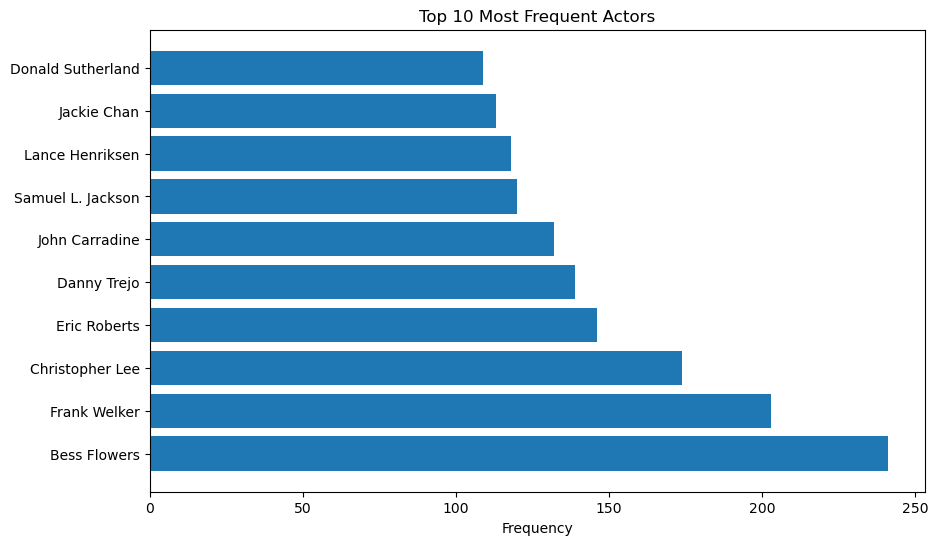

In [131]:
# Plotting top 10 actors
plt.figure(figsize=(10, 6))
labels, values = zip(*actor_counts.most_common(10))
plt.barh(labels, values)
plt.xlabel('Frequency')
plt.title('Top 10 Most Frequent Actors')
plt.show()